In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [2]:
INPUT_DIR = os.path.join("..","artifacts","raw")
df = pd.read_csv(os.path.join(INPUT_DIR,"animelist.csv"),low_memory=True,usecols = ['user_id','anime_id','rating'])

In [3]:
df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [4]:
len(df)

5000000

In [5]:
df.user_id.unique()

array([    0,     1,     2, ..., 16506, 16507, 16508], shape=(15186,))

In [6]:
#filtering users
n_ratings = df['user_id'].value_counts()
df = df[df['user_id'].isin(n_ratings[n_ratings>400].index)].copy()

In [7]:
df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [8]:
len(df)

3242641

In [9]:
min_rating = min(df.rating)
max_rating = max(df.rating)
df['rating'] = df['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)
print(min_rating)
print(max_rating)
print(min(df.rating))
print(max(df.rating))

0
10
0.0
1.0


In [10]:
user_id = df['user_id'].unique().tolist()
user2user_endcoded = {x:i for i,x in enumerate(user_id)}
user2user_decoded = {i:x for i,x in enumerate(user_id)}
df['user'] = df['user_id'].map(user2user_endcoded)

In [11]:
anime_ids = df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
df["anime"] = df["anime_id"].map(anime2anime_encoded)

In [12]:
df = df.sample(frac=1,random_state=42).reset_index(drop=True)

In [13]:
x = df[['user','anime']]
y = df['rating']
test_size = 1000
split_index = df.shape[0]-test_size
x_train,x_test,y_train,y_test = (x[:split_index],
                                 x[split_index:],
                                 y[:split_index],
                                 y[split_index:])

In [14]:
x_train.shape

(3241641, 2)

In [15]:
#converting data into numpy array
x_train_array = [x_train.iloc[:,0].to_numpy(),x_train.iloc[:,1].to_numpy()]
x_test_array = [x_test.iloc[:,0].to_numpy(),x_test.iloc[:,1].to_numpy()]


In [16]:
type(x_train_array[0])

numpy.ndarray

In [17]:
#model architecture
n_users = len(user2user_endcoded)
n_anime = len(anime2anime_encoded)
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [18]:
n_users

4193

In [19]:
model = RecommenderNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,782 (10.42 MB)

 Trainable params: 2,731,780 (10.42 MB)

 Non-trainable params: 2 (8.00 B)

In [20]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [21]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=10,monitor="val_loss",mode="min",restore_best_weights=True)
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [22]:
history = model.fit(
    x = x_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs  = 20,
    verbose = 1,
    validation_data = (x_test_array,y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.7924 - mae: 0.3807 - mse: 0.1947 - val_loss: 0.7167 - val_mae: 0.3650 - val_mse: 0.1652 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.7889 - mae: 0.3794 - mse: 0.1933 - val_loss: 0.7884 - val_mae: 0.3813 - val_mse: 0.1929 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.7831 - mae: 0.3772 - mse: 0.1910 - val_loss: 0.8006 - val_mae: 0.3836 - val_mse: 0.1968 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.7748 - mae: 0.3740 - mse: 0.1877 - val_loss: 0.7973 - val_mae: 0.3830 - val_mse: 0.1956 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.7634 - mae: 0.3694 - mse: 0.1830 - val_loss: 0.7910 - val_mae: 0.3815 - val_mse: 0.1932 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.7471 - mae: 0.3624 - mse: 0.1762 - v

In [23]:
model.load_weights(checkpoint_filepath)

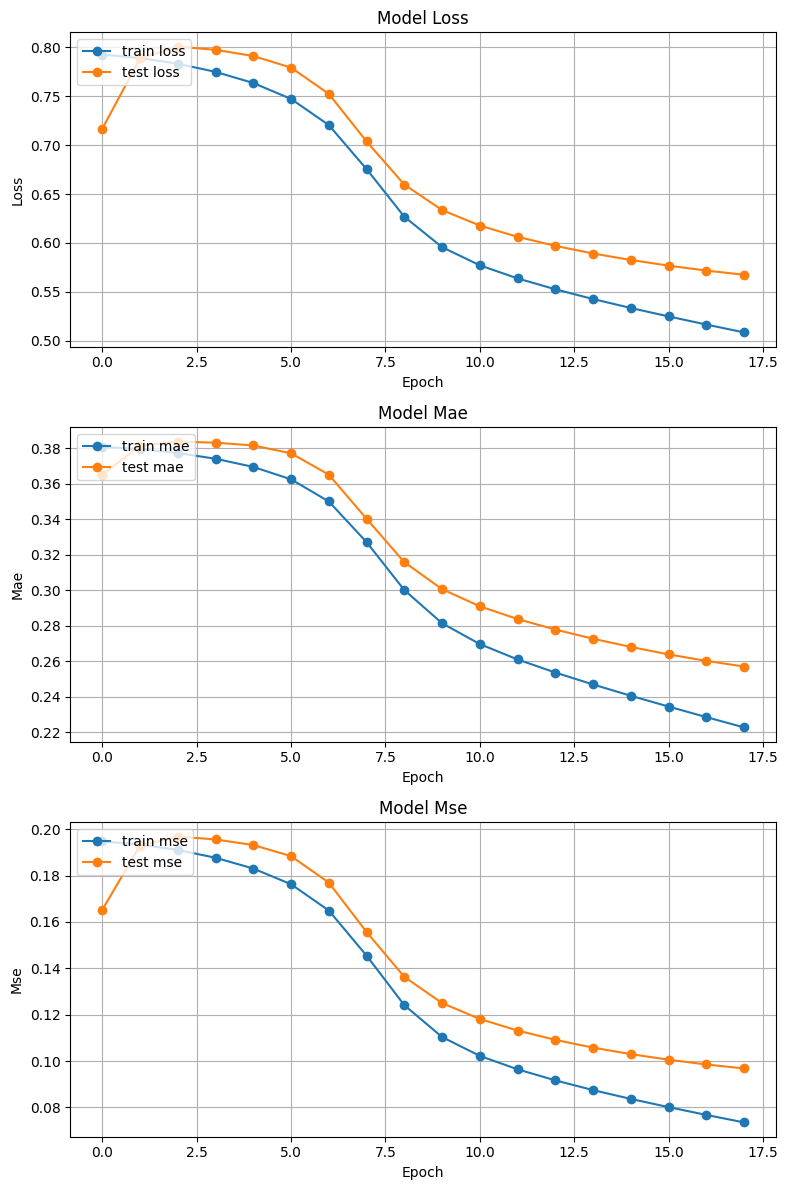

In [24]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [25]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis = 1).reshape((-1,1))
    return weights

In [26]:
anime_weights = extract_weights("anime_embedding",model)
user_weights = extract_weights("user_embedding",model)

In [27]:
#reading anime csv
df_anime = pd.read_csv(os.path.join(INPUT_DIR,'anime.csv'),low_memory = True)
df_anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [28]:
df_anime.replace('Unknown',np.nan, inplace=True)

In [29]:
df_anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [30]:
def getAnimeName(anime_id):
    try:
        name = df_anime[df_anime.anime_id==anime_id].eng_version.values[0]
        if name is np.nan:
            name = df_anime[df_anime.anime_id==anime_id].Name.values[0]
    except:
        print('Error')
    return name

In [31]:
df_anime["anime_id"] = df_anime["MAL_ID"]
df_anime["eng_version"] = df_anime["English name"]
df_anime["eng_version"] = df_anime.anime_id.apply(lambda x:getAnimeName(x))

In [32]:
getAnimeName(6702)

'Fairy Tail'

In [33]:
df_anime.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")
df_anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [34]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [35]:
getAnimeFrame(40028 , df_anime)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season


In [36]:
#animer with synopsis csv
cols = ["MAL_ID","Name","Genres","sypnopsis"]
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [37]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
getSynopsis(40028 , synopsis_df)
    

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [42]:
#recommender system

def find_similar(name,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n = 10,return_dist = False,neg= False):
    #getting anime id
    index = getAnimeFrame(name,df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)
    if encoded_index is None:
        raise ValueError(f"Encoded index not found in anime ID: {index}")
    weights = anime_weights

    #computing similarity distance
    dists = np.dot(weights,weights[encoded_index])
    sorted_dists = np.argsort(dists)
    n = n+1

    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [43]:
find_similar(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df_anime,
    synopsis_df,
)

,name,similarity,genre
9,Code Geass:Lelouch of the Rebellion R2,0.752442,"Action, Military, Sci-Fi, Super Power, Drama, ..."
8,Fullmetal Alchemist:Brotherhood,0.722816,"Action, Military, Adventure, Comedy, Drama, Ma..."
7,Angel Beats!,0.707460,"Action, Comedy, Drama, School, Supernatural"
6,One Punch Man,0.706917,"Action, Sci-Fi, Comedy, Parody, Super Power, S..."
5,Attack on Titan,0.692232,"Action, Military, Mystery, Super Power, Drama,..."
4,Fate/Zero Season 2,0.691282,"Action, Supernatural, Magic, Fantasy"
3,Code Geass:Lelouch of the Rebellion,0.689326,"Action, Military, Sci-Fi, Super Power, Drama, ..."
2,Death Note,0.674768,"Mystery, Police, Psychological, Supernatural, ..."
1,Your Name.,0.672520,"Romance, Supernatural, School, Drama"
0,Bakemonogatari,0.652175,"Romance, Supernatural, Mystery, Vampire"


In [44]:
#user based recommender system
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [46]:
find_similar_users(int(11880),user_weights,user2user_endcoded,user2user_decoded)

,similar_users,similarity
9,8592,0.421780
8,11697,0.406366
7,5324,0.398870
6,13137,0.391304
5,14638,0.387618
4,3651,0.386538
3,3106,0.384985
2,1483,0.375864
1,5401,0.375523
0,14874,0.373150


In [47]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [48]:
from collections import defaultdict

In [49]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [68]:
def get_user_preferences(user_id , df , df_anime ,plot=False):

    animes_watched_by_user = df[df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




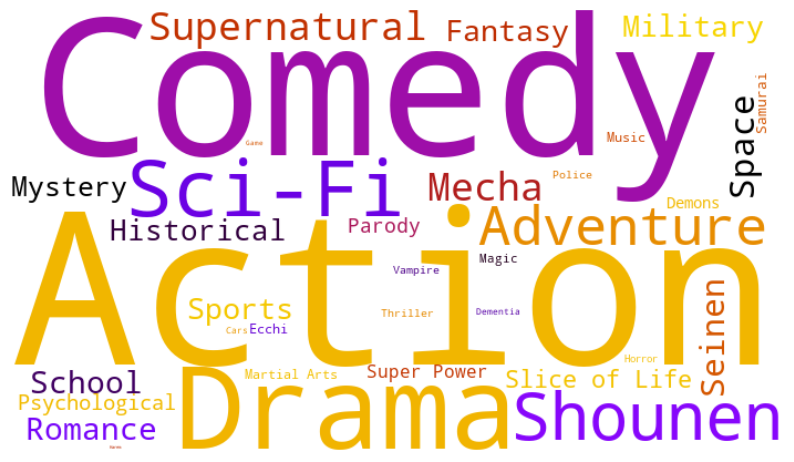

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [69]:
get_user_preferences(11880 , df, df_anime , plot=True)

In [73]:
def get_user_recommendations(similar_users , user_pref ,df_anime , synopsis_df, df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , df, df_anime)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df_anime)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [74]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_endcoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , df, df_anime)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df_anime, synopsis_df,df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df_anime, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

hybrid_recommendation(11880)

['Steins;Gate', 'Steins;Gate:The Movie − Load Region of Déjà Vu', 'Berserk', 'Death Note', 'Baka & Test - Summon the Beasts', 'Code Geass:Lelouch of the Rebellion R2', 'Code Geass:Lelouch of the Rebellion', 'Clannad', 'Aldnoah.Zero', 'No Game, No Life']


['Code Geass:Lelouch of the Rebellion R2',
 'Code Geass:Lelouch of the Rebellion',
 'Angel Beats!',
 'One Punch Man',
 'Death Note',
 'Attack on Titan',
 'Your Name.',
 'Steins;Gate',
 'Fullmetal Alchemist:Brotherhood',
 'Fate/Zero Season 2']

In [75]:
hybrid_recommendation(11880)

['Steins;Gate', 'Steins;Gate:The Movie − Load Region of Déjà Vu', 'Berserk', 'Death Note', 'Baka & Test - Summon the Beasts', 'Code Geass:Lelouch of the Rebellion R2', 'Code Geass:Lelouch of the Rebellion', 'Clannad', 'Aldnoah.Zero', 'No Game, No Life']


['Code Geass:Lelouch of the Rebellion R2',
 'Code Geass:Lelouch of the Rebellion',
 'Angel Beats!',
 'One Punch Man',
 'Death Note',
 'Attack on Titan',
 'Your Name.',
 'Steins;Gate',
 'Fullmetal Alchemist:Brotherhood',
 'Fate/Zero Season 2']